**Vivian Nguyen**

Spring 2023

CS 251: Data Analysis and Visualization

Project 7: Radial Basis Function Neural Networks

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import pca_cov
import warnings
warnings.filterwarnings('ignore')

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=5)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Task 1: RBF Network development dataset

The eventual goal is to train a neural network so that it learns to recognize which human handwritten digit is shown in an image  (i.e. the numbers 0, 1, ..., 9). Before doing this, you will use simpler data to develop and debug your network.

### 1a. Load and preprocess data

- Load in the `rbf_dev_train.csv` and `rbf_dev_test.csv` train and test sets.
- For the train and test sets, separate the data variables (`X` and `Y`) from the class values (*class*). The test code below assumes the following names:
    - `y_train` and `y_test` for the class values in the train and test sets, respectively.
    - `rbf_dev_train` and `rbf_dev_test` for the train and test set data, respectively.
- Normalize each data feature "separately" between 0 and 1 (based on each feature's dynamic range).
    - Use the `min` and `max` values derived from the training set to normalize the test set. *This will ensure that identical feature values in the training and test sets get normalized to the same numeric value.*

**Tip:** It might be a good idea to write a few functions below so that you don't have a lot of duplicate code when processing train and test sets.

In [ ]:
def load_data(filename, cols, flatten =False):
    data = pd.read_csv(filename, usecols= cols).to_numpy()

    if flatten == True:
        data =data.flatten()
    return data


def normalize(arr, min, max):
    
    normalized_arr = (arr - min)/ (max - min)
    return normalized_arr

rbf_dev_train= load_data('data/rbf_dev_train.csv', [0,1])


rbf_dev_train= normalize(rbf_dev_train, np.min(rbf_dev_train), np.max(rbf_dev_train))


rbf_dev_test = load_data('data/rbf_dev_test.csv', [0,1])
rbf_dev_test = normalize(rbf_dev_test, np.min(rbf_dev_test), np.max(rbf_dev_test))

y_train = load_data('data/rbf_dev_train.csv', [2], flatten= True)
y_train = normalize(y_train, np.min(y_train), np.max(y_train))
y_test = load_data('data/rbf_dev_test.csv', [2], flatten=  True) 
y_test = normalize(y_test, np.min(y_test), np.max(y_test))
# print(y_train)

#### Preprocessing test code

The following test code is a good sanity check, but you are encouoraged to do additional testing to make sure that your preprocessing pipeline is working properly.

##### Check dtypes

In [ ]:
print(f'Your training set is an ndarray? {isinstance(rbf_dev_train, np.ndarray)}')
print(f'Your training classes is an ndarray? {isinstance(y_train, np.ndarray)}')
print(f'Your test set is an ndarray? {isinstance(rbf_dev_test, np.ndarray)}')
print(f'Your test classes is an ndarray? {isinstance(y_test, np.ndarray)}')

Your training set is an ndarray? True
Your training classes is an ndarray? True
Your test set is an ndarray? True
Your test classes is an ndarray? True


##### Check shapes

In [ ]:
print(f'Your training set shape is {rbf_dev_train.shape} and should be (1600, 2).')
print(f'Your training classes shape is {y_train.shape} and should be (1600,).')
print(f'Your test set shape is {rbf_dev_test.shape} and should be (400, 2).')
print(f'Your test classes shape is {y_test.shape} and should be (400,).')

Your training set shape is (1600, 2) and should be (1600, 2).
Your training classes shape is (1600,) and should be (1600,).
Your test set shape is (400, 2) and should be (400, 2).
Your test classes shape is (400,) and should be (400,).


### 1b. Plot data

Create a scatter plot of the training data in the cell below.

- Color code each sample by its output class.
- Make the aspect ratio (height and width) of the x and y axes in the figure equal, otherwise the plot may look distorted.

If everything is working properly, you should see a jack-o-lantern whose eyes, noise, mouth, and stem are colored differently than the rest of the face.

Text(0.5, 1.0, 'Rbf Dev Training Data')

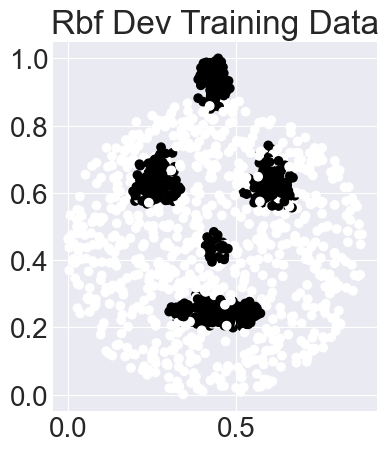

In [ ]:
plt.scatter(rbf_dev_train[:,0], rbf_dev_train[:,1], c= y_train)
plt.gca().set_aspect('equal')
plt.title('Rbf Dev Training Data')

## Task 2: Radial basis function neural network

In [ ]:
from rbf_net import RBF_Net

### 2a. Network initalization

You will use K-means to initialize the RBF hidden layer prototypes and sigmas.

1. Copy over your `kmeans.py` from your previous project. If your K-means clustering code isn't working properly, you may use `scipy` functions in this project instead, but at a 1 point reduction. Check out `scipy.cluster.vq.kmeans`.

2. Implement the method templates in `rbf.py` that initialize the hidden layer of the neural network:
    - Finish writing the constructor
    - `get_num_hidden_units`
    - `get_num_output_units`
    - `avg_cluster_dist`: Compute the average distance between each cluster center found by K-means and all the points assigned to the same cluster.
    - `initialize`: Use K-means to set the Gaussian hidden unit centers (**prototypes**) and standard deviations (**sigmas**).


In [ ]:
from kmeans import KMeans

#### Test `avg_cluster_dist`

In [ ]:
np.random.seed(0)

# N = 10 samples, M = 5 features
test_data = np.random.normal(size=(10, 5))
# 4 hidden units / prototypes, each has 5 features
test_centroids = np.random.normal(size=(4, 5))
# Each sample assigned to one of 4 hidden unit prototypes
test_assignments = np.random.randint(low=0, high=4, size=(10,))
kmeansObj = KMeans()

test_net = RBF_Net(4, 3)
print(f'Number of hidden units in your net is {test_net.get_num_hidden_units()} and should be 4')
print(f'Number of output units in your net is {test_net.get_num_output_units()} and should be 3')
test_clust_mean_dists = test_net.avg_cluster_dist(test_data, test_centroids, test_assignments, kmeansObj)

print(f'Your avg within cluster distances are\n{test_clust_mean_dists} and should be\n[2.23811 3.94891 3.12267 3.4321]')

Number of hidden units in your net is 4 and should be 4
Number of output units in your net is 3 and should be 3
Your avg within cluster distances are
[2.23811 3.94891 3.12267 3.4321 ] and should be
[2.23811 3.94891 3.12267 3.4321]


#### Test `initialize`

In [ ]:
np.random.seed(0)
test_net.initialize(test_data)

print(f'Your prototypes have shape {test_net.get_prototypes().shape} and the shape should be (4, 5).')
print(f'Your hidden unit sigmas have shape {test_net.sigmas.shape} and the shape should be (4,).')

Your prototypes have shape (4, 5) and the shape should be (4, 5).
Your hidden unit sigmas have shape (4,) and the shape should be (4,).


#### Test initialization methods

In the cell below, write test code for your RBF network initialization:
- Create a new RBF network with 7 hidden units and 2 output classes.
- Call the `initalize` method on it, passing in the training data.
- Create a class color-coded scatterplot of the training data with an equal axis aspect ratio, like above, now with the prototypes clearly marked with a different marker and/or color.

You should see fairly evenly distributed prototypes, with one in most, if not all, "pockets" of samples belonging to a single class.

Text(0.5, 1.0, 'Rbf Dev Training Data with Prototypes')

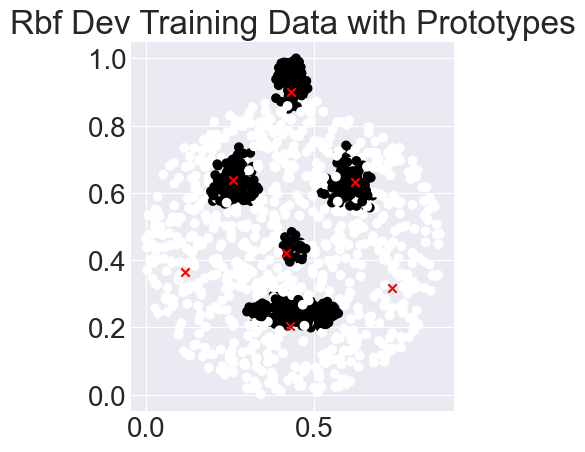

In [ ]:
np.random.seed(0)

rbf_net = RBF_Net(7,2)
rbf_net.initialize(rbf_dev_train)
# print(rbf_net.get_prototypes())

plt.scatter(rbf_dev_train[:,0], rbf_dev_train[:,1], c= y_train)
plt.scatter(rbf_net.get_prototypes()[:,0],rbf_net.get_prototypes()[:,1], marker = 'x', color = 'red')
plt.gca().set_aspect('equal')
plt.title('Rbf Dev Training Data with Prototypes')

**Question 1:** Do you think the prototypes enable the RBF network to learn the data well? Why or why not?

**Answer 1:** 

I do think the prototypes enable the RBF network to learn the data well. Visually, the prototypes are representative of where the classes are. There is a prototype in basically every cluster of a class which sets the network up to correctly learn how to classify points in the data.

### 2b. Compute hidden and output layer activations

Implement the following methods so that you can train your RBF network:
- `hidden_act`: Computes hidden layer activation values: Determines the similarity between hidden layer prototypes with the input data.
- `output_act`: Computes output layer activation values: Multiply hidden unit activation by output unit weights.

**Hidden unit activation**:

The activation of hidden unit $j$ to data sample $i$ is computed according to $$H_{ij} = \exp \left (-\frac{\text{dist} \left (\vec{x}_i, \vec{c}_j \right )^2}{2\sigma_j^2 + \epsilon}\right )$$ 
where $\vec{x_i}$ is the data sample, $\vec{c_j}$ is the prototype (center) of the hidden unit, $\sigma_j$ is the hidden unit's standard deviation, $\epsilon$ is a small number (e.g. 1e-8), and $dist(\cdot, \cdot)^2$ is the **squared** Euclidean distance.

#### Test hidden_act

In [ ]:
np.random.seed(1)

# N = 3 samples, M = 5 features
test_data = np.random.normal(size=(3, 5))
# 4 hidden units / prototypes, each has 5 features
test_centroids = np.random.normal(size=(4, 5))
# Each sample assigned to one of 4 hidden unit prototypes
test_sigmas = np.random.uniform(size=(4,))
test_wts = 2*np.random.uniform(size=(4+1, 3)) - 1

test_net = RBF_Net(4, 3)
test_net.prototypes = test_centroids
test_net.sigmas = test_sigmas
test_net.wts = test_wts
test_h_act = test_net.hidden_act(test_data)
print(f'Your hidden layer activation is\n{test_h_act}\n\nand should be')
print('[[0.      0.      0.00009 0.00033]\n [0.00013 0.      0.00004 0.00014]\n [0.      0.      0.      0.00001]]')

Your hidden layer activation is
[[0.      0.      0.00009 0.00033]
 [0.00013 0.      0.00004 0.00014]
 [0.      0.      0.      0.00001]]

and should be
[[0.      0.      0.00009 0.00033]
 [0.00013 0.      0.00004 0.00014]
 [0.      0.      0.      0.00001]]


#### Test output_act

In [ ]:
test_out_act = test_net.output_act(test_h_act)
print(f'Your output layer activation is\n{test_out_act}\n\nand should be')
print('[[-0.72136  0.61505 -0.20481]\n [-0.72151  0.61487 -0.20466]\n [-0.72144  0.61479 -0.20465]]')

Your output layer activation is
[[-0.72136  0.61505 -0.20481]
 [-0.72151  0.61487 -0.20466]
 [-0.72144  0.61479 -0.20465]]

and should be
[[-0.72136  0.61505 -0.20481]
 [-0.72151  0.61487 -0.20466]
 [-0.72144  0.61479 -0.20465]]


### 2c. Learn network weights using linear regression

To train your RBF network, you will need to find optimal weights between hidden and output layer neurons to allows your network to accurately classify the training data (i.e. learn from the data). An efficient solution is to use linear regression to solve a least square problem: minimizing the squared difference between the *hidden layer activations* and the *true data classes*.

- **CS251:** In `rbf.py`, implement `linear_regression(A, y)`. To do this, adapt your code from the linear regression project involving `scipy.linalg.lstsq()` or `numpy.linalg.lstsq()`.
- **CS252:** In `rbf.py`, implement `linear_regression(A, y)`. To do this, adapt your code in `linear_regression` to use your QR solver.

#### Test linear regression

Running the following test code should generate a familar regression fit to the Iris data.

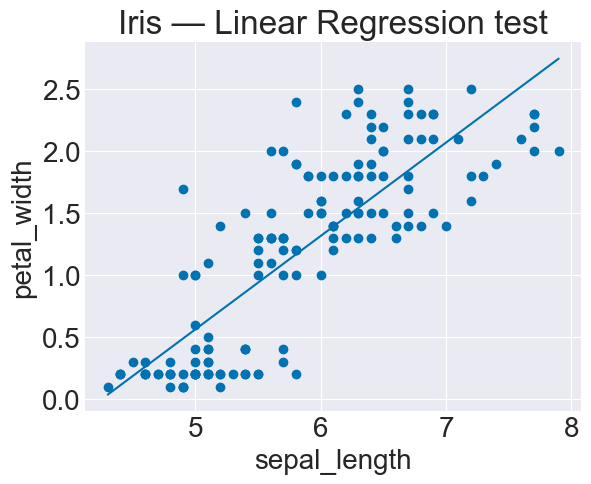

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/uiuc-cse/data-fa14/gh-pages/data/iris.csv')
iris = df[['sepal_length', 'petal_width']].to_numpy()

num_hidden_units = 1
num_classes = 4
net = RBF_Net(num_classes=num_classes, num_hidden_units=num_hidden_units)
iris_x = np.reshape(iris[:, 0], [len(iris), 1])
iris_y = np.reshape(iris[:, 1], [len(iris), 1])
iris_c = net.linear_regression(iris_x, iris_y)

line_x = np.linspace(iris_x.min(), iris_x.max())
line_y = line_x * iris_c[0] + iris_c[1]
plt.scatter(iris_x, iris_y)
plt.plot(line_x, line_y)
plt.title('Iris — Linear Regression test')
plt.xlabel('sepal_length')
plt.ylabel('petal_width')
plt.show()

### 2d. Train your RBF Network

Implement the following methods then train your neural network! In the cell below, train a RBF network with 10 hidden units on the RBF dev dataset. **If everything is working, you should get >=88% accuracy on the training set and >=89% on the test set.**

- `train`: Determine the optimal output layer weights that fit hidden layer activation using linear regression.
- `predict`: Use trained network (after learning) to predict the class of data.
- `accuracy`: Compute the accuracy by comparing the network predicted and actual class for each data sample.



In [ ]:
rbf_net = RBF_Net(10,2)
rbf_net.train(rbf_dev_train, y_train)

y_pred = rbf_net.predict(rbf_dev_train)

In [ ]:
# Training set accuracy
train_acc = rbf_net.accuracy(y_train, y_pred)
print('Train Data Accuracy: ', train_acc)

Train Data Accuracy:  0.886875


In [ ]:
# Test set accuracy

y_pred_test = rbf_net.predict(rbf_dev_test)
test_acc = rbf_net.accuracy(y_test, y_pred_test)
print('Test Data Accuracy: ', test_acc)

Test Data Accuracy:  0.8975


## Task 3: Handwritten digit classification: MNIST data

You will train a RBF network on a "real" image dataset of handwritten number digits:
- 60,000 images in training set, 10,000 images in test set.
- Each image is 28x28 pixels.
- The images are grayscale (no RGB colors).
- Each image (data sample) contains ONE of 10 numeric digit $0, 1, 2, \ldots, 8, 9$.

The goal is to train your network so that it can correctly predict the numeric digit in an image.

More information about MNIST: http://yann.lecun.com/exdb/mnist/

### 3a. Load in and look at MNIST dataset

- Use the numpy function `load` to load in the MNIST train/test data and the associated class labels.
- Create a 5x5 grid showing the first 25 images in the dataset. It should "look good" (e.g. turn off tick marks).

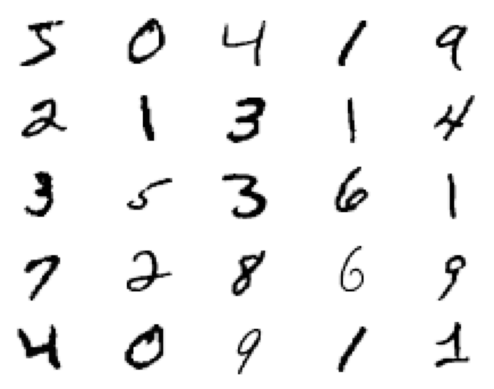

In [ ]:
x_train = np.load('data/mnist_train_data.npy')
x_test = np.load('data/mnist_test_data.npy')
y_train = np.load('data/mnist_train_labels.npy')
y_test = np.load('data/mnist_test_labels.npy')

# print(x_train)
fig, axs = plt.subplots(5,5)

for i, ax in enumerate(axs.flat):
    if i < len(x_train):
        img = (x_train[i])
        ax.imshow(img)
        ax.axis('off')
        

In [ ]:
print(f'Your training set shape is {x_train.shape} and should be (60000, 28, 28).')
print(f'Your training classes shape is {y_train.shape} and should be (60000,).')
print(f'Your test set shape is {x_test.shape} and should be (10000, 28, 28).')
print(f'Your test classes shape is {y_test.shape} and should be (10000,).')

Your training set shape is (60000, 28, 28) and should be (60000, 28, 28).
Your training classes shape is (60000,) and should be (60000,).
Your test set shape is (10000, 28, 28) and should be (10000, 28, 28).
Your test classes shape is (10000,) and should be (10000,).


### 3b. Preprocess data

- Flatten non-leading dimensions of the train and test sets. For example, the training set should go from (60000, 28, 28) to (60000, 784). **Do not hard code this!** Your code should work for any data with three dimensions.
- Normalize so that the maximum possible value in each image is 1 (and the minimum possible is 0) by dividing by 255.

In [ ]:


def preprocess(arr):
    shape = arr.shape
    flatten_num = shape[1] * shape[2]
    flattened = arr.reshape((shape[0], flatten_num))
    normalized_arr = np.divide(flattened, 255)
    return normalized_arr

train = preprocess(x_train)
print(train.shape)
print(train)

test = preprocess(x_test)


(60000, 784)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### 3c. Train and assess performance on MNIST

Train a RBF network on MNIST. **Your goal is to get >=90% accuracy on both train and test sets.**

**Tips:**
- Depending on your laptop or machine you are using, training could take many hours if you use the full 60,000 sample training set. Select a subset to train on (e.g. ~1500) that takes a reasonable amount of time (e.g. minutes). You should be able to hit your accuracy goals without too much data, effort, or time.
- Do not pare down the test set (i.e. it should remain at 10,000 samples).
- Use the code below to visualize your hidden layer prototypes to help with debugging (assumes your network is called `mnist_net`). Your prototypes should look like images of certain digits, perhaps a little blurrier.

In [ ]:
mnist_net = RBF_Net(200,10)
start = time.time()
mnist_net.train(train[:1500],y_train[:1500] )
y_pred= mnist_net.predict(train)
end = time.time()
runtime = end - start
print('Runtime: ', runtime)

Runtime:  36.9235680103302


In [ ]:
# train acc
mnist_net.accuracy(y_train, y_pred)

0.90495

In [ ]:
# test acc
test_pred = mnist_net.predict(test)
mnist_net.accuracy(test_pred, y_test)

0.9084

Text(0.5, 0.98, 'Hidden Layer Prototypes')

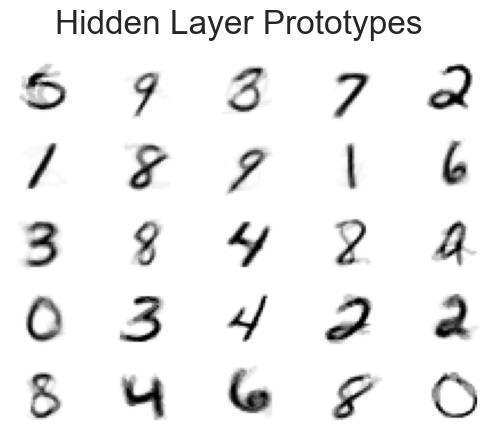

In [ ]:
# Visualize network hidden layer prototypes
prototypes = mnist_net.get_prototypes()
prototypes = np.reshape(prototypes, [prototypes.shape[0], 28, 28])

cols = rows = 5
fig, axes = plt.subplots(nrows=rows, ncols=cols)
for i in range(rows):
    for j in range(cols):
        axes[i, j].imshow(prototypes[i*rows + j])
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

fig.suptitle('Hidden Layer Prototypes')

**Question 2:** Which part of the training process takes the longest?

**Answer 2:** 
The kmeans clustering of the training process takes the longest.

**Question 3:** What accuracy did you achieve on the training set? List all parameters that you needed to set (e.g. number of training samples, number hidden units, etc).

**Answer 3:** 

On the training set, I achieved an accuracy of 0.90495. I used 200 hidden units and 1500 training samples. 

**Question 4:** Using the same parameters to get the training accuracy that you reported in Question 3, what test accuracy did you achieve?

**Answer 4:**

Using the same parameters, the test accuracy was 0.9084.

## Extensions

To receive credit for any extension, you must:
- Not modify / prevent any code from the core project from working (e.g. make a copy before changing). In other words, **the notebook test code should still work!**
- **You must describe what you did and what you found in detail**. This includes a summary of parameter values used in your simulations.
- Include (*labeled!*) plots and/or numbers to present your results.
- Write up your extensions below or in a separate notebook.

**Rule of thumb: one deep, thorough extension is worth more than several quick, shallow extensions!**

### 1) Improve performance on MNIST with PCA

Using all 768 features (pixels) in each image may not be very helpful for classification. For example, pixels around the border are almost always white. Transform the dataset(s) using PCA to compress the number of features before training your RBF network. Experiment with PCA to improve classification accuracy and runtime performance.

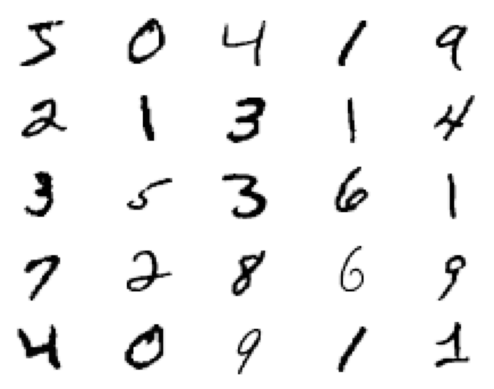

In [ ]:
# Copied and pasted visualization of first 25 digits from above
fig, axs = plt.subplots(5,5)

for i, ax in enumerate(axs.flat):
    if i < len(x_train):
        img = (x_train[i])
        ax.imshow(img)
        ax.axis('off')

In [ ]:
# Note: data is already preprocessed from the above code cells so I don't have to do it again

# Performing PCA

digits = pd.DataFrame(train)

pca = pca_cov.PCA_COV(digits)
vars = np.arange(0,784)
pca.pca(vars)


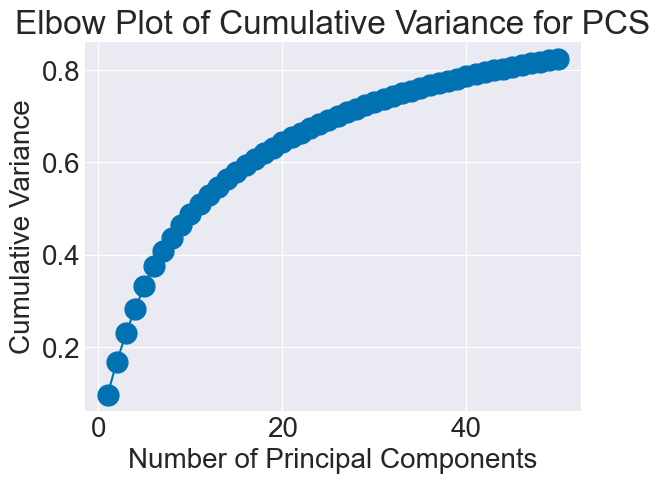

In [ ]:
pca.elbow_plot(50)

In [ ]:
# taken from project 4
def make_imgs(reconstucted_imgs):
    '''Inflates a 1D feature vector representation of images into 2D images for plotting.
    Assumes square images
    
    Parameters:
    -----------
    reconstucted_imgs: ndarray. shape=(N, img_y*img_x)
        1D vector representation of each image
    
    Returns:
    -----------
    ndarray. shape=(N, img_y, img_x)
        The images inflated into 2D
    '''
    N, img_yx= reconstucted_imgs.shape
    reshaped = reconstucted_imgs.reshape(N, int(np.sqrt(img_yx)), int(np.sqrt(img_yx))) 
    return reshaped

(60000, 784)
PCA Runtime:  72.46402215957642
PCA Accuracy:  0.9112833333333333


Text(0.5, 0.98, 'Digits with 50 Principal Components')

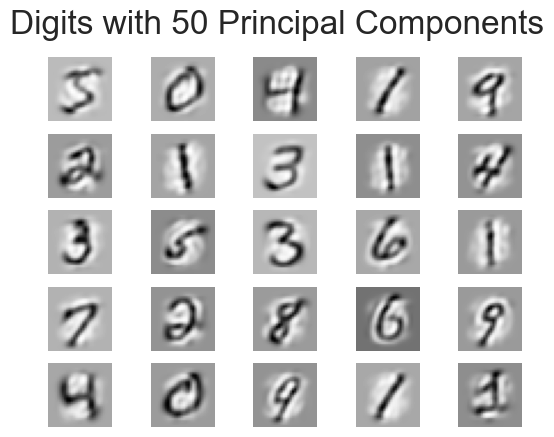

In [ ]:
# pd.options.mode.chained_assignment = None
# Using the elbow plot, I've decided on keeping 50 principal components to maintain an 0.8 cumulative variance
reconstructed_imgs = pca.pca_then_project_back(50)
print(reconstructed_imgs.shape)

start = time.time()
rbf_net_pca = RBF_Net(200, 10)
rbf_net_pca.train(reconstructed_imgs[:1500], y_train[:1500])
end = time.time()
pred = rbf_net_pca.predict(reconstructed_imgs)
end = time.time()
pca_runtime = end - start
print('PCA Runtime: ', pca_runtime)
print('PCA Accuracy: ',rbf_net_pca.accuracy(y_train, pred))
x = make_imgs(reconstructed_imgs)
# print(x.shape)

fig, axs = plt.subplots(5,5)
for i, ax in enumerate(axs.flat):
    if i < len(x):
        img = (x[i]).astype(float)
        # print(type(img))
        ax.imshow(img )
        ax.axis('off')
fig.suptitle('Digits with 50 Principal Components')



Extension: 

For this extension, I attempted to use PCA to reduce the dimensionality of the datasets so that the rbf training would be quicker. I had hypothesized that by reducing the dimensionality, the rbf would run faster because there's less uneccesary things that it has to run through.

I imported the PCA methods that I wrote for Project 4. I ran pca and then created an elbow plot to see what how many principal components I should keep. I decided on 50 as that gave me roughly 0.8 cumulative variance. I then projected the data back to only the 50 pcs and used it to run the rbf. I also plotted the reduced data, and the numbers are still legible, but the white space around them is removed.

I expected the rbf to run faster, but it actually ran slower than before the pca. The normal data had a runtime of about 36 seconds, but the pca data had a runtime of 72 seconds. I experimented with different amounts of pcs to see if that would bring the runtime down. When the pc amount was very high, the runtime was slightly reduced by a few seconds. I also checked to see what part of the rbf process was taking longer. The training for PCA data only took about 6 seconds, but the predict method was about 66 seconds. Perhaps the pca data took longer to run because the reduction took away elements and thus made the classification more difficult.

### 2) Visualize network predictions

Make visualizations to show and interpret the MNIST network predictions. Lots of possibilities, here are a few specific ideas:
- Make show a grid of test samples labeled with their predicted digit.
- Analyze if the network performance favors accuracy for certain digits and not others.
- Are errors on certain classes correlated in any way? Does it depend on their digit similarity (e.g. 1 looks like a 7, but not a 0).
- Make and interpret a confusion plot.

### 3) Explore parameter space

When training your RBF network on MNIST, you had to pick some parameter values to use by hand. Pick one or more parameters and systematically vary them to quantify their effect on accuracy and simulation time.

In [ ]:
# Changing the hidden unit amount
train_accs = []
test_accs = []
runtimes = []
num_hidden = []
for i in range(1,700, 100):
    num_hidden.append(i)
    start = time.time()
    net = RBF_Net(i, num_classes=10)
    net.train(train[:1500], y_train[:1500])
    predictions = net.predict(train)
    tr_acc = net.accuracy(y_train, predictions)
    
    test_predictions = net.predict(test)
    tes_acc =net.accuracy(y_test, test_predictions)
    end = time.time()
    runtimes.append(end - start)
    train_accs.append(tr_acc)
    test_accs.append(tes_acc)
    
max_train_idx = np.argmax(train_accs)
max_test_idx = np.argmax(test_accs)
min_time_idx = np.argmin(runtimes)



print('Train Data Accuracies: ', train_accs)
print('Highest Accuracy: ', train_accs[max_train_idx], ' at ', num_hidden[max_train_idx], 'hidden numbers')
print('Test Data Accuracies: ',test_accs)
print('Highest Accuracy: ', test_accs[max_test_idx], ' at ', num_hidden[max_test_idx], 'hidden numbers')
print('Runtimes: ',runtimes)
print('Lowest Runtime: ', runtimes[min_time_idx], ' at ', num_hidden[min_time_idx], 'hidden numbers')

Train Data Accuracies:  [0.20088333333333333, 0.8812666666666666, 0.90235, 0.9081333333333333, 0.9126166666666666, 0.91405, 0.90915]
Highest Accuracy:  0.91405  at  501 hidden numbers
Test Data Accuracies:  [0.2012, 0.8858, 0.906, 0.9126, 0.9141, 0.9177, 0.9144]
Highest Accuracy:  0.9177  at  501 hidden numbers
Runtimes:  [0.5890870094299316, 21.49506115913391, 42.7171151638031, 64.22928524017334, 86.26786589622498, 108.51853513717651, 129.04729104042053]
Lowest Runtime:  0.5890870094299316  at  1 hidden numbers


Extension:

In the project, I hand-picked the amount of hidden numbers. I landed on 200 for the project just because it gave me the accuracy I was looking for, and it didn't take too long to compute. For this extentsion, I tested 7 different hidden numbers amounts from 1 to 700 with a stepsize of 100. This gave me a wide range of hidden number amounts to analyze. The lowest runtime was with 1 hidden number which makes sense because there is the least computation there as there are less prototypes. As the hidden_number amount increases, the runtime also increases.

The accuracies for the training and the testing datasets were both the highest at 501 hidden numbers. The more hidden numbers, the higher the accuracies because the rbf network can better understand the data and its patterns. It is likely that increasing the hidden numbers past this point leads to overfitting which is why is why only 501 numbers yields the best results. 

### 4) Initialization schemes

Research, test out, and quantify the performance of different techniques to set the hidden unit prototypes and sigmas. For example, an alternative way to initialize the prototypes is to perform K-means to cluster each class *separately*. 

### 5) Other datasets

Use your RBF network to classify other datasets.

### 6) SVD-based linear regression

Implement a SVD-based linear regression method, which is both fast and numerically accurate. In the equation $Ac = y$ The weights $c$ can be solved via the following matrix equation: $$c = A^+y$$ where $A^+$ is the pseudo inverse of the matrix of RBF hidden layer activations $A$ (*data matrix*) and the correct classes $y$.

Relying on numpy to figure out the pseudoinverse would be a mini extension, computing the pseudoinverse yourself would be a larger extension.

### 7) Analyze the trained network

Run simulations then analyze and interpret the results. Here are some ideas:
- Visualize and analyze how the prototypes influence the classification results.
- Visualize and analyze how the network weights influence the classification results.

### 8) RBF networks for regression (CS252)

- Analyze the regression neural network's performance in scenarios when the training set is not equal to the training set.
- Explore and analyze how the RBF network could perform regression on a function with several inputs (e.g. $z = f(x, y)$). Test with real or simulated data.
- Explore and analyze how the RBF network could perform regression on a vector valued function with several outputs (e.g. $(y, z) = f(x)$). Test with real or simulated data.